In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pltlab

import numpy as np
import scipy 
import pickle
import pandas as pd
import scipy.stats
from pathlib import Path
import os
from tqdm import tqdm

%matplotlib inline

# plt.rcParams['figure.dpi'] = 200
import seaborn as sns
sns.set(color_codes=True)


In [3]:
AGENT_LIST = ["rs-PI", "adv-rs-PI", "s-opt", "h-opt", ]

# Prepare coefficients list
# Note: all coeffs need to be >=0
LAMBDA_R_vals = [1.0, 0.0]
LAMBDA_C_vals = [1.0, 0.0]
LAMBDA_COEFFS = [(lr, lc) for lc in LAMBDA_C_vals for lr in LAMBDA_R_vals]

# for the delta agents no 0,0
LAMBDA_COEFFS.remove((0.0,0.0))

## Hyper-params associated with best_params

In [4]:
SEED_LIST = range(0,10)

ENV_NAME = 'large_grid-200' 

# base for all the logs 
BASE_PATH = "enter/path/here"

### Load the DF and merge them

In [7]:
# Load the df 

df_indv_list = []

for seed in SEED_LIST:
    seed_df = pd.read_csv(filepath_or_buffer=f"{BASE_PATH}/{ENV_NAME}/s_{seed}/results.csv")
    
    # within a saved df all run starts from 0 
    # add an identifier to them for now
    seed_df['run_id'] = seed_df['run_id'] + seed*100
    
    #append to the list for concatenation
    df_indv_list.append(seed_df)
    

results_df = pd.concat(df_indv_list)

results_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27200 entries, 0 to 2719
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     27200 non-null  int64  
 1   run_id                         27200 non-null  int64  
 2   gamma                          27200 non-null  float64
 3   cost_limit                     27200 non-null  float64
 4   nb_states                      27200 non-null  int64  
 5   nb_actions                     27200 non-null  int64  
 6   nb_trajectories                27200 non-null  int64  
 7   ratio                          27200 non-null  float64
 8   pib_R_true_performance         27200 non-null  float64
 9   pib_C_true_performance         27200 non-null  float64
 10  piSolution_R_true_performance  27200 non-null  float64
 11  piSolution_C_true_performance  27200 non-null  float64
 12  agent_name                     27200 non-null  

In [8]:
# num of diff runs 
NUM_RUNS = results_df.run_id.unique().shape[0]
NUM_RUNS

100

In [9]:
results_df.nb_trajectories.unique()

array([  10,   50,  500, 2000])

In [10]:
results_df.shape

(27200, 19)

In [11]:
# Dataset generation hyper-parameters
NB_TRAJ_LIST = results_df.nb_trajectories.unique()
RATIO_LIST  = results_df.ratio.unique()

## Util functions

In [12]:
def coeff_to_str(lr = 1.0, lc = 1.0):
    """
    converts the coeffs to string formatting required by pandas 
    """
    return f'{float(lr)}_{float(lc)}'

In [13]:
def normalize_returns(df, low=0.0, high=1.0):
    """
    does the following for both R and C:
        - centers the data around baseline performance (by subtracting pi_b)
        - normalize the centered values of the solution in [low, high] range
    """
    
    # copy to work on a duplicate and don't modify orginal
    normalized_df = df.copy()
        
    # do normalizaation for R  
    r_min, r_max = df['piSolution_R_true_performance'].min(), df['piSolution_R_true_performance'].max()
    normalized_df['piSolution_R_true_performance'] = (df['piSolution_R_true_performance'] - r_min) / (r_max - r_min) * (high - low) + low
    normalized_df['pib_R_true_performance'] = (df['pib_R_true_performance'] - r_min) / (r_max - r_min) * (high - low) + low
    
    # do normalizaation for C
    c_min, c_max = df['piSolution_C_true_performance'].min(), df['piSolution_C_true_performance'].max()
    normalized_df['piSolution_C_true_performance'] = (df['piSolution_C_true_performance'] - c_min) / (c_max - c_min) * (high - low) + low
    normalized_df['pib_C_true_performance'] = (df['pib_C_true_performance'] - c_min) / (c_max - c_min) * (high - low) + low

    # all the true returns are now normalized in this new df    
    return normalized_df

In [14]:
def select_agent_df(df, agent_name):
    """
    filters the df based on the agent type
    """
    if agent_name == 'reg-PI':
        agent_df = df[df['agent_name'] == 'Unconstrained_PI']
    elif agent_name == 'rs-PI':
        agent_df = df[df['agent_name'] == 'Reshaped_PI']
    elif agent_name == 'adv-rs-PI':
        agent_df = df[df['agent_name'] == 'Reshaping_Adv_PI']
    elif agent_name == 's-opt':
        agent_df = df[df.agent_name.str.contains('S_OPT')]
    elif agent_name == 'h-opt':
        agent_df = df[df.agent_name.str.contains('H_OPT')]
    else: 
        raise Exception('unkown agent')
        
    return agent_df

In [15]:
def add_linearized_return(df, coeff):
    """
    does the following for both R and C:
        - centers the data around baseline performance (by subtracting pi_b)
        - normalize the centered values of the solution in [low, high] range
        
    returns a copy of df 
    """
    # copy to work on a duplicate and don't modify orginal
    copy_df = df.copy()
        
    # do normalizaation for policies
    copy_df['piSolution_linearized_return'] = (coeff[0] * df['piSolution_R_true_performance']) - (coeff[1] * df['piSolution_C_true_performance'])

    # for the baseline
    copy_df['pib_linearized_return'] = (coeff[0] * df['pib_R_true_performance']) - (coeff[1] * df['pib_C_true_performance'])
    
    # net improvement over baseline
    copy_df['improved_return'] = copy_df['piSolution_linearized_return'] - copy_df['pib_linearized_return']
    
    return copy_df

In [16]:
def add_safety_check(df):
    """
    adds a new column to df checks if that run satisfies the constraints or not
    """
    copy_df = df.copy()
    copy_df['is_safe'] =  (df['piSolution_R_true_performance'] >= df['pib_R_true_performance']) &\
                         (df['piSolution_C_true_performance'] <= df['pib_C_true_performance'])

    return copy_df

## Matplot lib utils

In [17]:
MARKER_DICT = { "s-opt" : '*', 
               "h-opt" : 's', 
               "reg-PI" : '>', #
               "rs-PI" : '<', #
               "adv-rs-PI": 'v', #d
              }

# marler info can be found https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers 
# use 'o', 'd', 'D'

MARKER_SIZE = 5

MARKER_OPACITY = 0.75

In [18]:
AGENT_LABEL_DICT = { "s-opt" : 'S-OPT', 
                    "h-opt" : 'H-OPT', 
                    "reg-PI" : 'Unconstrained', 
                    "rs-PI" : 'Linearized', 
                    "adv-rs-PI": 'Adv-Linearized', #d
                   }

AGENT_COLOR_DICT = { "s-opt" : 'red', 
                    "h-opt" : 'blue', 
                    "reg-PI" : 'black', #prev green -> now black
                    "rs-PI" : 'green', #orange -> green
                    "adv-rs-PI": 'violet',
                   }


In [19]:
def create_custom_colormap(tags, scheme='viridis', top_k=0.8):
    """
    tags: associated with each bin (unique list)
    
    creates a custom color map that works for discrete ints
    
    source: https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
    """
    bins = len(tags)+1
#     cmap = pltlab.cm.jet
    if scheme == 'dark':
        cmap = pltlab.cm.Dark2
    elif scheme == 'viridis':
        cmap = pltlab.cm.viridis
    elif scheme == 'plasma':
        cmap = pltlab.cm.plasma
    else:
        raise Exception('unk color scheme')
    
    # extract all colors from the default map
    cmaplist = [cmap(i) for i in range(int(top_k * cmap.N))]
        
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    
    # define the bins and normalize
    bounds = np.linspace(0, bins-1, bins)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    return cmap, norm, bounds    

## Plot single run

In [29]:
def plot_results_for_lambda_rho(ax_imp, ax_failure, df, lR, lC, ratio, normalize=False, plot=True, print_=False):
    """
    two plots for each combination
    """
    results_dict = {}
    
    # create the lambda string
    coeff_str =  coeff_to_str(lR, lC)
    # get filter/index the dataframe 
    condition =  df.ratio.eq(ratio) & df.coeff.eq(coeff_str)
    filtered_df = df[condition]
    
    # can't be empty
    assert filtered_df.shape[0] > 0
   
    # Get the unconstrainted agent too
    # it is independent of reward weighing (coeffs) but depends on ratio here 
    unconst_df = df[(df['agent_name'] == 'Unconstrained_PI')  & (df['ratio']==ratio)]
    
    # add it to the filtered_df
    trajs_and_agents_df = pd.concat([filtered_df, unconst_df]).copy()
    
    if normalize:
        # the results for all the plots will be normalized using the same scaling
        trajs_and_agents_df = normalize_returns(trajs_and_agents_df, low=0.0, high=1.0)
    
    # add a new column for the linearized_performance
    trajs_and_agents_df = add_linearized_return(trajs_and_agents_df, (lR, lC))
    
    # add the safety column
    trajs_and_agents_df = add_safety_check(trajs_and_agents_df)
    
    # get the baseline performance for this condition
    assert trajs_and_agents_df.run_id.unique().shape[0] == NUM_RUNS
    
    # now plot for each agent 
    for agent_name in AGENT_LIST:
    
        # init empty dict
        results_dict[agent_name] = {}

        for traj_idx, nb_traj in enumerate(NB_TRAJ_LIST):
            # plots across trajs here 
            # filter the result based on nb_traj
            agent_traj_df = trajs_and_agents_df[(trajs_and_agents_df['nb_trajectories']==nb_traj)]

            # filter the agent 
            agent_df = select_agent_df(agent_traj_df, agent_name)

            # only one agent for each run
            assert agent_df.run_id.unique().shape[0] == NUM_RUNS
    
            # get the improvement 
            imp_mean = np.mean(agent_df.improved_return)
            imp_std = np.std(agent_df.improved_return)
            imp_sem = scipy.stats.sem(agent_df.improved_return)
    
            # get the failure rate 
            failure_rate_mean = np.mean(1. - agent_df.is_safe)
            failure_rate_std = np.std(1. - agent_df.is_safe)
            failure_rate_sem = scipy.stats.sem(1. - agent_df.is_safe)
            
            # save the results 
            results_dict[agent_name][nb_traj] = {'imp_mean' : imp_mean, 
                                                 'imp_std' : imp_std,
                                                 'imp_sem' : imp_sem,
                                                 'failure_rate_mean' : failure_rate_mean,
                                                 'failure_rate_std' :failure_rate_std,
                                                 'failure_rate_sem' :failure_rate_sem,
                                                 'imp_list' : agent_df.improved_return.to_list(), 
                                                 'fail_list' : (1. - agent_df.is_safe).to_list(), 
                                                }
            
            if print_:
                print(f"{agent_name} with {nb_traj}\t L:{imp_mean:0.2f} +/- {imp_std:0.2f}\t \tFailure rate:{failure_rate_mean:0.2f} +/- {failure_rate_std:0.2f}")
            
        # plot here
        if plot:
            
            # plot the line for that agent 
            # create x-makers
            x_range = np.arange(len(NB_TRAJ_LIST)) + 1.0
            
            ax_imp.errorbar(x=x_range, 
                            y=[results_dict[agent_name][nb_traj]['imp_mean'] for nb_traj in NB_TRAJ_LIST], 
                            yerr=[results_dict[agent_name][nb_traj]['imp_sem'] for nb_traj in NB_TRAJ_LIST],  
                            marker=MARKER_DICT[agent_name], 
#                             ms=MARKER_SIZE, 
                            label= AGENT_LABEL_DICT[agent_name],
                            alpha = MARKER_OPACITY,
                            c = AGENT_COLOR_DICT[agent_name]
                        )
    
            ax_failure.errorbar(x=x_range, 
                                y= [results_dict[agent_name][nb_traj]['failure_rate_mean'] for nb_traj in NB_TRAJ_LIST], 
                                yerr=[results_dict[agent_name][nb_traj]['failure_rate_sem'] for nb_traj in NB_TRAJ_LIST],  
                                marker=MARKER_DICT[agent_name], 
#                                 ms=MARKER_SIZE,
                                label= AGENT_LABEL_DICT[agent_name],
                                alpha = MARKER_OPACITY,
                                c = AGENT_COLOR_DICT[agent_name]
                               )

        
    if plot:
        # Final plotting details 

        # plot the baseline stats
        ax_imp.axhline(y= 0.0, linestyle=":", c="black")
        ax_failure.set_ylim([-0.2, 1.2])
        
        # hard code delta
        ax_failure.axhline(y= 0.1, label = f"$\delta$=0.1", linestyle="--", c='black')        
        
        # put labels and stuff
        # only label on the lower axis
        ax_failure.set_xticks(np.arange(len(NB_TRAJ_LIST))+1.0)
        ax_failure.set_xticklabels(NB_TRAJ_LIST, fontsize=12)
        ax_failure.set_xlabel('$|\mathcal{D}|$ - num of trajectories', fontsize=14)
        # y-labels
        ax_failure.set_ylabel('Failure Rate', fontsize=14)
        ax_imp.set_ylabel(f"Improvement over $\pi_b$", fontsize=14)
        # remove -0.2, 1.2 ticks
        ax_failure.set_yticks(ax_failure.get_yticks()[1:-1])
        
        
        

    return results_dict

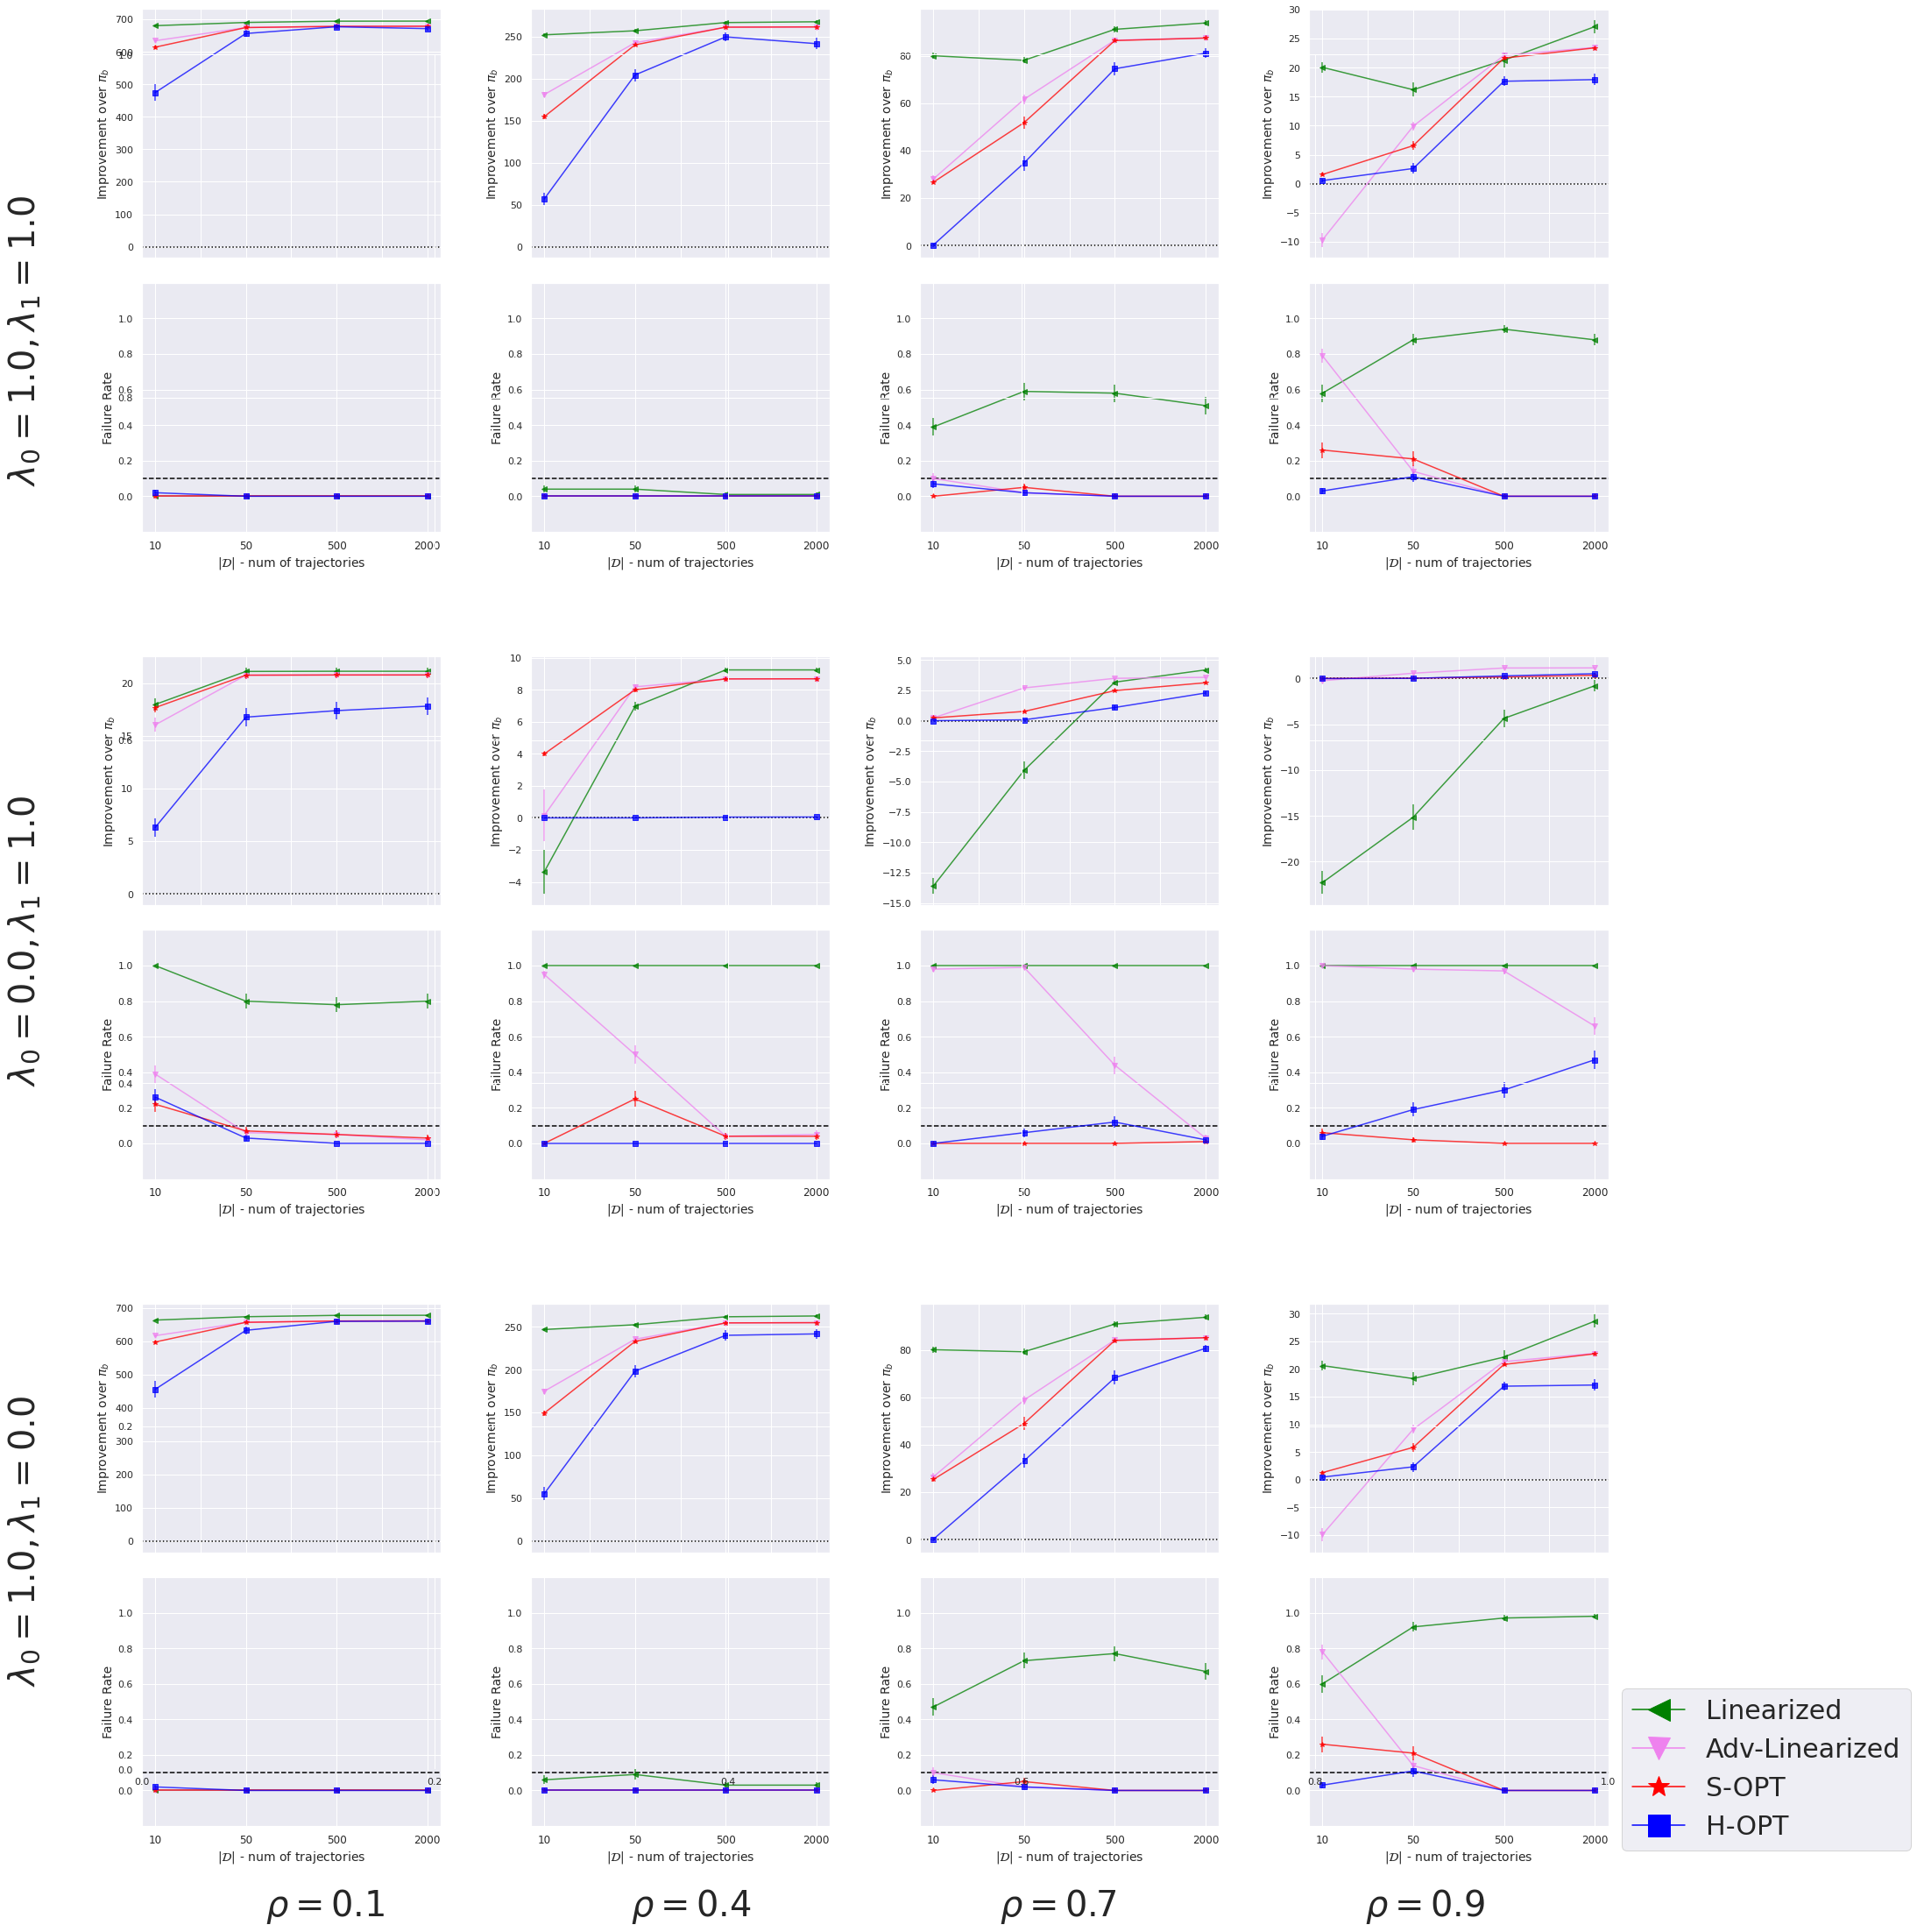

In [30]:

# same as the above 
FIG_LEN = 30 # 36

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

n = len(LAMBDA_COEFFS) # number of double-rows, |coeffs|
m = len(RATIO_LIST) # number of columns

t = 0.9 # 1-t == top space 
b = 0.1 # bottom space      (both in figure coordinates)

msp = 0.1 # minor spacing
sp = 0.5  # major spacing

offs=(1+msp)*(t-b)/(2*n + n*msp + (n-1)*sp) # grid offset
hspace = sp+msp+1 #height space per grid
wspace = 0.3

gso = GridSpec(n,m, bottom=b+offs, top=t, hspace=hspace, wspace=wspace)
gse = GridSpec(n,m, bottom=b, top=t-offs, hspace=hspace, wspace=wspace)

fig = plt.figure(figsize=(FIG_LEN, FIG_LEN*1.2)) #w,h , more lenghty

axes = []
imp_axes = []
fail_axes = []


for i, coeff in enumerate(LAMBDA_COEFFS):
    for j, ratio in enumerate(RATIO_LIST):
        # set the axis first 
        ax_imp = fig.add_subplot(gso[i, j])
#         ax_imp.text(0.5, 0.5, f"Imp-ax({i},{j})", va="center", ha="center")
        ax_imp.tick_params(labelbottom=False)
        
        ax_safe = fig.add_subplot(gse[i, j])
#         ax_safe.text(0.5, 0.5, f"Safe-ax({i},{j})", va="center", ha="center")
        
        # plot the axes 
        plot_results_for_lambda_rho(ax_imp, ax_safe, results_df, 
                                    lR=coeff[0], lC=coeff[1], 
                                    ratio=ratio, 
                                    normalize=False, 
                                    print_=False, 
                                    plot=True)

        
# add the grid labels
nr_rows = n
nr_cols = m

fig.add_subplot(111, frameon=False)
# define the rows and columns
xranges = [f"$\\rho={i}$" for i in RATIO_LIST]
yranges = [f"$\\lambda_{{0}}={i[0]},\\lambda_{{1}}={i[1]}$" for i in LAMBDA_COEFFS]

for pos, text in enumerate(xranges):
    plt.text(pos * (1/nr_cols) + 0.5*(1/nr_cols), -0.08, text, fontsize=40, ha='center', va='center')

# this place bottom to top, whereas rows are generated top to bottom    
for pos, text in enumerate(yranges[::-1]):
    plt.text(-0.08, (pos*1.05)* (1/nr_rows) + 0.4*(1/nr_rows), text, fontsize=40, ha='center', va='center', rotation='vertical')

    
# add the legend here manually
import matplotlib.lines as mlines

legend_elements = []
for agent in AGENT_LIST:
    legend_elements.append(mlines.Line2D([0], [0], marker=MARKER_DICT[agent], 
                                         color=AGENT_COLOR_DICT[agent], 
                                         label=AGENT_LABEL_DICT[agent],
#                                          markerfacecolor='gold', 
                                         markersize=25) )

    
# add legend elements for the baselines
# legend_elements.append(mlines.Line2D([0], [0], color='b',  linestyle=":", label="$J_{R}(\pi_{b} , M^{\star})$", lw=4) )
# legend_elements.append(mlines.Line2D([0], [0], color='r',  linestyle="-.", label="$J_{C}(\pi_{b} , M^{\star})$", lw=2) )


# Create the figure
# cordinates are now wrt to ax2
plt.legend(handles=legend_elements, bbox_to_anchor=(1.0, 0.0), loc='center left', prop={'size':30})

    
plt.show()




## Cumulative plot

In [25]:
def stat_search_cum_agent(result_dict, agent,flag='imp'):
    """
    returns an array containting the mean
    
    # TODO: later 
    # for std need to make a whole function again
    """
    result_mean = []
    result_err = []
    
    for nb_traj in NB_TRAJ_LIST:
        vals = []
        
        for coeff in LAMBDA_COEFFS:
            for ratio in RATIO_LIST:
                
                if flag == 'imp':
                    vals += result_dict[coeff][ratio][agent][nb_traj]['imp_list']
                else:
                    vals += result_dict[coeff][ratio][agent][nb_traj]['fail_list']                
        
        # take the mean of that put in final array
        result_mean.append(np.mean(vals))
#         result_err.append(np.std(vals))
        result_err.append(scipy.stats.sem(vals))
    
    return result_mean, result_err

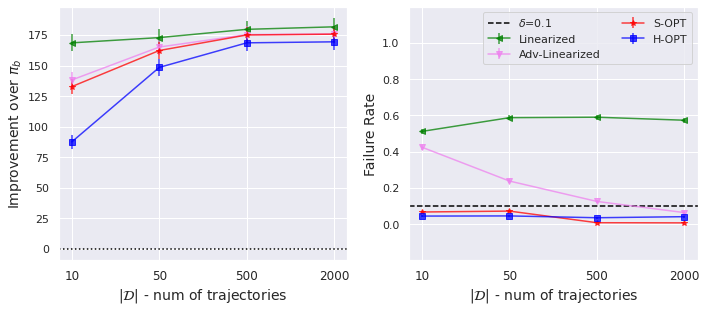

In [31]:
# get all the results first 
cum_dict = {}

#
# fig, axes = plt.subplots(2, 1, figsize=(6,8), sharex=True)
fig, axes = plt.subplots(1, 2, figsize=(10,4.5))

for i, coeff in enumerate(LAMBDA_COEFFS):
    
    cum_dict[coeff] = {}
    for j, ratio in enumerate(RATIO_LIST):
        exp_result = plot_results_for_lambda_rho(None, None, results_df, 
                                    lR=coeff[0], lC=coeff[1], 
                                    ratio=ratio, 
                                    normalize=False, 
                                    print_=False, 
                                    plot=False)

        cum_dict[coeff][ratio] = exp_result

# Have all the results now just gotta plot them for each agent 




for agent_name in AGENT_LIST:
    
    x_range = np.arange(len(NB_TRAJ_LIST)) + 1.0    
    imp_mean, imp_errs = stat_search_cum_agent(cum_dict, agent_name, flag='imp')
    fail_mean, fail_errs = stat_search_cum_agent(cum_dict, agent_name, flag='fail')    
    
    axes[0].errorbar(x_range, 
                     imp_mean, 
                     yerr=imp_errs,
                     marker=MARKER_DICT[agent_name], 
                     label= AGENT_LABEL_DICT[agent_name],
                     alpha = MARKER_OPACITY,
                     c = AGENT_COLOR_DICT[agent_name]
                    )
    
    axes[1].errorbar(x_range, 
                     fail_mean, 
                     yerr=fail_errs,
                 marker=MARKER_DICT[agent_name], 
                 label= AGENT_LABEL_DICT[agent_name],
                 alpha = MARKER_OPACITY,
                 c = AGENT_COLOR_DICT[agent_name]
                 )
    
axes[0].axhline(y= 0.0, linestyle=":", c="black")
axes[1].set_ylim([-0.2, 1.2])
axes[1].axhline(y= 0.1, label = f"$\delta$=0.1", linestyle="--", c='black')        
        
# put labels and stuff
# only label on the lower axis
# for 0 
axes[0].set_xticks(np.arange(len(NB_TRAJ_LIST))+1.0)
axes[0].set_xticklabels(NB_TRAJ_LIST, fontsize=12)
axes[0].set_xlabel('$|\mathcal{D}|$ - num of trajectories', fontsize=14)
# for 1
axes[1].set_xticks(np.arange(len(NB_TRAJ_LIST))+1.0)
axes[1].set_xticklabels(NB_TRAJ_LIST, fontsize=12)
axes[1].set_xlabel('$|\mathcal{D}|$ - num of trajectories', fontsize=14)
# y-labels
axes[1].set_ylabel('Failure Rate', fontsize=14)
axes[0].set_ylabel(f"Improvement over $\pi_b$", fontsize=14)
        
axes[1].set_yticks(axes[1].get_yticks()[1:-1])


plt.legend(ncol=2)
fig.tight_layout()    
    
plt.show()


